# Quantitative Model Training Notebook
This Notebook is designed to determine the empirical parameters needed to estimate concentration ratios from Raman intensity ratios. It requires given pre-processed input spectra generated by the OSTRI_Raman-Processing Notebook, which must be carefully baselined to ensure generation of an accurate model. The model uses bootstrapping to estimate fitting and prediction errors, which requires 10+ spectra per sample.

Once the model has fitted the data and generated best-fit values for empirical parameters FXJ, FXB, and JA, these parameters can be used to predict concentration ratios from intensity ratios using the OSTRI_Model-Testing Notebook.

In [1]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './synthetic data/'
Fig_dir = './new figures/'
Out_dir = './synthetic output/'
Ref_dir = './data/Standards/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# default parameters for data point locations
C_min = 10**-1  # min A concentration (in ppm)
C_max = 10**5   # max A concentration (in ppm)
C_samples = 20  # number of data points to generate

# number of values to generate per point
N_values = 100        # int, or list of ints with length C_samples

Scenario = 1

# define instrumental parameters for generating data
Params = {
    'I_v0': 1.,       # incident laser intensity
    'F_v1': 1.,       # instrument sensitivity factor at v1
    'F_v2': 1.,       # instrument sensitivity factor at v2
    'J_A1': 50.,      # raman cross-section for A, v1
    'J_A2': 5.,       # raman cross-section for A, v2
    'J_B1': 0.001,    # raman cross-section for B, v1
    'J_B2': 0.02,     # raman cross-section for B, v2
    'X_v1': 1.,       # sample attenuation factor at v1
    'X_v2': 1.        # sample attenuation factor at v2
}

# define noise levels
Dark_Noise = 100.     # st.dev. of fluctuations in absolute signal
Shot_Noise = 0.2      # st.dev. of fluctuations in relative signal

# background noise values is dark_noise * shot_noise
# peak noise is (background_noise + signal) * noise

# random number generator seed (set to None for true randomness, set to number for replicable results)
Seed = 1001

Components = ['A', 'B']

# specify which components to use as A and B
Evaluation_Components = ['A', 'B']

# Specify whether to bootstrap resample data (needed to estimate errors, requires 10+ spectra per sample)
Bootstrap = True
N_Bootstraps = 1000

Laser_Wavelength = '248'        # wavelength in nm, as str

In [2]:
# ==================================================
# this section imports necessary python modules

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

# import VibSpec module functions
from OSTRI_functions import *

# generate output folders
if not os.path.exists(Fig_dir):
    os.makedirs(Fig_dir)
if not os.path.exists(Out_dir):
    os.makedirs(Out_dir)

# ==================================================
# define any additional functions here

def generate_data(CA, CB, params={}, n_values=1, dark_noise=0., shot_noise=0., rng_seed=626, return_all=False, debug=False):
    # function for generating synthetic intensity ratio data from input parameters
    
    # clean up input
    if type(n_values) != int:
        n_values = int(n_values)
    for key in ['J_A1', 'J_A2', 'J_B1', 'J_B2', 'F_v1', 'F_v2', 'X_v1', 'X_v2', 'I_v0']:
        if key not in params.keys():
            raise Exception("params dict missing %s value!" % key)
        else:
            params[key] = np.float64(params[key])
    dark_noise = np.float64(dark_noise)
    shot_noise = np.float64(shot_noise)
    if debug == True:
        print("dark: %0.1E" % dark_noise)
        print("shot: %0.1E" % shot_noise)
    
    CR = np.asarray(CA, dtype=np.float64) / np.asarray(CB, dtype=np.float64)
    
    # generate clean data
    I1_clean = params['I_v0'] * params['F_v1'] * params['X_v1'] * (CA * params['J_A1'] + CB * params['J_B1'])
    I2_clean = params['I_v0'] * params['F_v2'] * params['X_v2'] * (CA * params['J_A2'] + CB * params['J_B2'])
    
    # expand arrays for bootstrapping
    I1_clean = np.tile(I1_clean[:, np.newaxis], (1, n_values))
    I2_clean = np.tile(I2_clean[:, np.newaxis], (1, n_values))
        
    # duplicate arrays for noise generation
    I1_noise = np.copy(I1_clean)
    I2_noise = np.copy(I2_clean)
    
    rng = np.random.default_rng(rng_seed)
    
    # add dark noise
    if dark_noise > 0:
        I1_noise += rng.normal(0., dark_noise, size=np.shape(I1_noise))
        I2_noise += rng.normal(0., dark_noise, size=np.shape(I2_noise))
    
    # add shot noise
    if shot_noise > 0:
        I1_noise *= rng.normal(1., shot_noise, size=np.shape(I1_noise))
        I2_noise *= rng.normal(1., shot_noise, size=np.shape(I2_noise))
        
    # get intensity ratios
    IR_clean = I1_clean / I2_clean
    IR_noise = I1_noise / I2_noise
    
    print("generated data array:", np.shape(IR_clean), np.shape(IR_noise))
    
    # convert to data storage array
    if return_all == True:
        keys = ['CA', 'CB', 'CR', 'I1_clean', 'I2_clean', 'IR_clean', 'I1_noise', 'I2_noise', 'IR_noise']
        arrays = [CA, CB, CR, I1_clean, I2_clean, IR_clean, I1_noise, I2_noise, IR_noise]
    else:
        keys = ['CR', 'IR_clean', 'IR_noise']
        arrays = [CR, IR_clean, IR_noise]
        
    # return results
    return {key: array for key, array in zip(keys, arrays)}

def get_true_parameters(F, X, J, A, B):
    truths = {
        'FXJ': F*X*J,
        'FXB': F*X*B,
        'JA': J*A,
        'FXJ_JA': np.inf
    }
    if J*A > 0:
        truths['FXJ_JA'] = (F*X*J) / (J*A)
    return truths

# ==================================================
# automatically adjust parameters based on chosen scenario

if Scenario in [2,4]:
    Params['J_A2'] = 0.
if Scenario in [3,4]:
    Params['J_B1'] = 0.

Truths = get_true_parameters(Params['F_v1']/Params['F_v2'], Params['X_v1']/Params['X_v2'],
                             Params['J_A1'] / Params['J_B2'], Params['J_A2'] / Params['J_A1'], Params['J_B1'] / Params['J_B2'])

print()
print("input data parameters")
for key, val in Truths.items():
    print("%6s: %0.1E" % (key, val))
    
if Scenario == 1:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
elif Scenario == 2:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
elif Scenario == 3:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
else:
    X_Lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}


input data parameters
   FXJ: 2.5E+03
   FXB: 5.0E-02
    JA: 2.5E+02
FXJ_JA: 1.0E+01


# Synthetic Data Generation
- this section generates data based on pre-defined parameters

GENERATING SYNTHETIC DATASET 1...
generated data array: (20, 100) (20, 100)
(20, 100)
I1_noise
   CR 1.0E-07 = IR 1.1E+03 +/- 2.4E+02
   CR 2.1E-07 = IR 1.0E+03 +/- 2.3E+02
   CR 4.3E-07 = IR 1.0E+03 +/- 2.1E+02
   CR 8.9E-07 = IR 1.0E+03 +/- 2.2E+02
   CR 1.8E-06 = IR 1.1E+03 +/- 2.5E+02
   CR 3.8E-06 = IR 1.2E+03 +/- 2.6E+02
   CR 7.8E-06 = IR 1.4E+03 +/- 3.1E+02
   CR 1.6E-05 = IR 1.8E+03 +/- 3.9E+02
   CR 3.4E-05 = IR 2.7E+03 +/- 5.8E+02
   CR 7.0E-05 = IR 4.5E+03 +/- 9.3E+02
   CR 1.4E-04 = IR 8.2E+03 +/- 1.7E+03
   CR 3.0E-04 = IR 1.6E+04 +/- 2.9E+03
   CR 6.2E-04 = IR 3.2E+04 +/- 6.0E+03
   CR 1.3E-03 = IR 6.5E+04 +/- 1.1E+04
   CR 2.6E-03 = IR 1.4E+05 +/- 2.7E+04
   CR 5.5E-03 = IR 2.8E+05 +/- 5.3E+04
   CR 1.1E-02 = IR 5.5E+05 +/- 9.9E+04
   CR 2.4E-02 = IR 1.2E+06 +/- 2.3E+05
   CR 5.1E-02 = IR 2.4E+06 +/- 4.6E+05
   CR 1.1E-01 = IR 5.1E+06 +/- 1.0E+06
I2_noise
   CR 1.0E-07 = IR 2.0E+04 +/- 3.8E+03
   CR 2.1E-07 = IR 2.0E+04 +/- 4.2E+03
   CR 4.3E-07 = IR 2.0E+04 +/- 3.9E+03

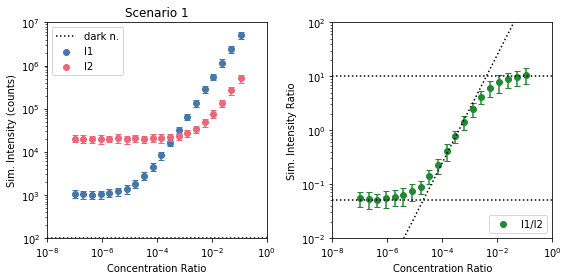

In [4]:
# key for this dataset
d_key = '1'

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# set up data storage dictionary
data = {}

print("GENERATING SYNTHETIC DATASET %s..." % d_key)

# generate input concentrations (in ppm)
CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
CB = 1000000. - CA

# ==================================================
# generate dataset

data[d_key] = generate_data(CA, CB, Params, N_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                            rng_seed=Seed, return_all=True)

print(np.shape(data[d_key]['IR_clean']))

# ==================================================
# create summary figure for this dataset

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.set_title("Scenario %s" % Scenario)
# plot absolute intensities vs concentration ratio
x_key = 'CR'
y_keys = ['I1_noise', 'I2_noise']
y_labels = ['I1', 'I2']
x = data[d_key][x_key]
y = np.asarray([np.nanmean(data[d_key][key], axis=1) for key in y_keys])
y_err = np.asarray([np.nanstd(data[d_key][key], axis=1) for key in y_keys])
for i, key in enumerate(y_keys):
    ### plt.plot(x, np.nanmean(data[d_key][key[:3]+"clean"], axis=1), Colour_List[i], linestyle=':')
    ax.errorbar(x, y[i], yerr=y_err[i], fmt='none', ecolor=Colour_List[i], capsize=3, zorder=2+0.1*i)
    ax.scatter(x, y[i], c=Colour_List[i], label=y_labels[i], zorder=2+0.1*i)
    print(key)
    for i2 in range(np.size(x)):
        print("   CR %0.1E = IR %0.1E +/- %0.1E" % (x[i2], y[i,i2], y_err[i,i2]))
if Dark_Noise > 0:
    ax.axhline(Dark_Noise, c='k', linestyle=':', label='dark n.', zorder=1.5)
ax.set_xlabel("Concentration Ratio")
check = np.logical_and(x > 0, ~np.isnan(x))
ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
ax.set_xscale('log')
ax.set_ylabel("Sim. Intensity (counts)")
y = np.concatenate(y)
check = np.logical_and(y > 0, ~np.isnan(y))
ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
ax.set_yscale('log')
ax.legend()

ax = plt.subplot(122)
# plot intensity ratio vs concentration ratio
x_key = 'CR'
y_keys = ['IR_noise']
y_labels = ['I1/I2']
x = data[d_key][x_key]
y = np.asarray([np.nanmean(data[d_key][key], axis=1) for key in y_keys])
y_err = np.asarray([np.nanstd(data[d_key][key], axis=1) for key in y_keys])
for i, key in enumerate(y_keys):
    ### plt.plot(x, np.nanmean(data[d_key][key[:3]+"clean"], axis=1), Colour_List[i], linestyle=':')
    ax.errorbar(x, y[i], yerr=y_err[i], fmt='none', ecolor=Colour_List[2+i], capsize=3, zorder=2+0.1*i)
    ax.scatter(x, y[i], c=Colour_List[2+i], label=y_labels[i], zorder=2+0.1*i)
ax.set_xlabel("Concentration Ratio")
check = np.logical_and(x > 0, ~np.isnan(x))
ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
ax.set_xscale('log')
ax.set_ylabel("Sim. Intensity Ratio")
y = np.concatenate(y)
check = np.logical_and(y > 0, ~np.isnan(y))
ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
ax.set_yscale('log')
if plot_truths == True:
    ax.plot(ax.get_xlim(), Truths['FXJ'] * np.asarray(ax.get_xlim()), 'k:')
    if Truths['FXB'] > 0:
        ax.axhline(Truths['FXB'], c='k', linestyle=':')
    if Truths['JA'] > 0:
        ax.axhline(Truths['FXJ_JA'], c='k', linestyle=':')
ax.legend(loc='lower right')

# finish figure
plt.tight_layout()
if save_plot == True:
    plt.savefig("%ssim_dataset_scenario%s.png" % (Fig_dir, Scenario), dpi=300)
if show_plot == True:
    plt.show()
else:
    plt.close()

input arrays: (20,) (20, 100)

 bootstrapping input data, N = 1000
      input data array: (20, 100)
     output data array: (20, 1000)

 proceeding with bootstrap modelling, N = 1000
 100/1000 ( 10%) models fitted
 200/1000 ( 20%) models fitted
 300/1000 ( 30%) models fitted
 400/1000 ( 40%) models fitted
 500/1000 ( 50%) models fitted
 600/1000 ( 60%) models fitted
 700/1000 ( 70%) models fitted
 800/1000 ( 80%) models fitted
 900/1000 ( 90%) models fitted
 1000/1000 (100%) models fitted

 FXJ:
           truth: 2.5E+03
            mean: 2.6E+03
          median: 2.6E+03
           stdev: 3.9E+01 (1.507%)
   min-max range: 2.4E+03 - 2.7E+03

 FXB:
           truth: 5.0E-02
            mean: 5.3E-02
          median: 5.3E-02
           stdev: 6.7E-04 (1.276%)
   min-max range: 5.0E-02 - 5.5E-02

 JA:
           truth: 2.5E+02
            mean: 2.4E+02
          median: 2.4E+02
           stdev: 6.4E+00 (2.641%)
   min-max range: 2.3E+02 - 2.7E+02

 FXJ_JA:
           truth: 1.0E+01
  

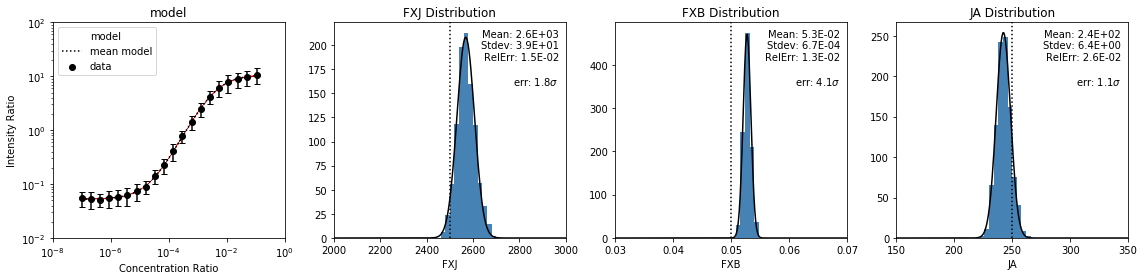

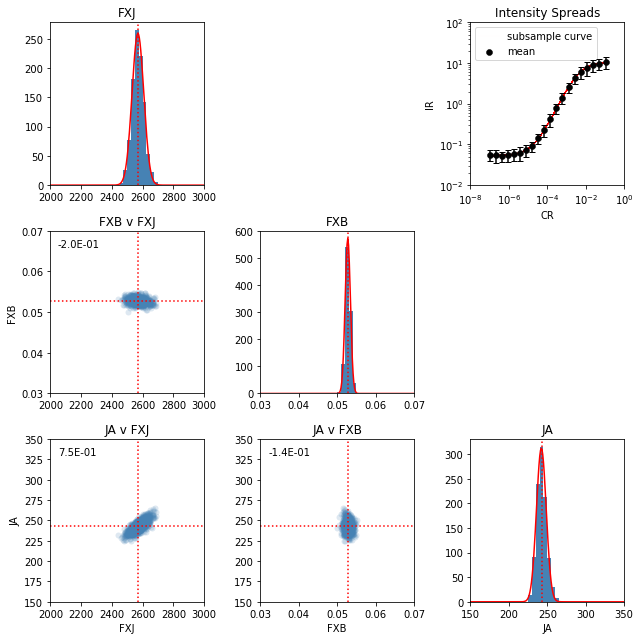

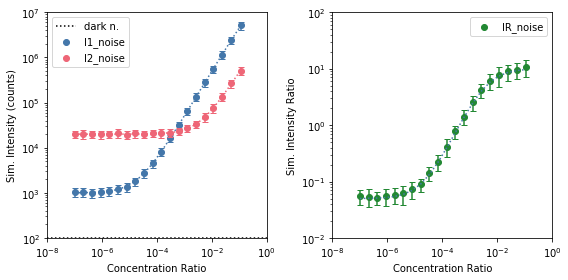

In [13]:
# ==================================================
# fit model to this dataset
d_key = '1'

x_key = 'CR'
y_key = 'IR_noise'
if N_values > 1 and Bootstrap == True:
    # get data
    x = data[d_key][x_key]
    y = data[d_key][y_key]
    print("input arrays:", np.shape(x), np.shape(y))
    # fit models using bootstrap method
    model, cov_matrix, bootstrap_results = bootstrap_intensity_fit_script(x, y, truths=Truths, x_lims=X_Lims,
                                        show_plot=show_plot, save_plot=save_plot, fig_dir=Fig_dir, debug=True)
else:
    # get data
    x = data[d_key][x_key]
    y = data[d_key][y_key]
    if y.ndim == 2:
        # reduce data to 1D if needed
        y = np.nanmean(y, axis=1)
    print("input arrays:", np.shape(x), np.shape(y))
    # fit model to data
    model = intensity_fit_script(x, y, debug=True)

# ==================================================
# create summary figure for this dataset

plt.figure(figsize=(8,4))
plt.subplot(121)
# plot absolute intensities vs concentration ratio
x_key = 'CR'
y_keys = ['I1_noise', 'I2_noise']
x = data[d_key][x_key]
y = np.asarray([np.nanmean(data[d_key][key], axis=1) for key in y_keys])
y_err = np.asarray([np.nanstd(data[d_key][key], axis=1) for key in y_keys])
for i, key in enumerate(y_keys):
    plt.plot(x, np.nanmean(data[d_key][key[:3]+"clean"], axis=1), Colour_List[i], linestyle=':')
    plt.errorbar(x, y[i], yerr=y_err[i], fmt='none', ecolor=Colour_List[i], capsize=3, zorder=2+0.1*i)
    plt.scatter(x, y[i], c=Colour_List[i], label=key, zorder=2+0.1*i)
if Dark_Noise > 0:
    plt.axhline(Dark_Noise, c='k', linestyle=':', label='dark n.', zorder=1.5)
plt.xlabel("Concentration Ratio")
check = np.logical_and(x > 0, ~np.isnan(x))
plt.xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
plt.xscale('log')
plt.ylabel("Sim. Intensity (counts)")
y = np.concatenate(y)
check = np.logical_and(y > 0, ~np.isnan(y))
plt.ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
plt.yscale('log')
plt.legend()

plt.subplot(122)
# plot intensity ratio vs concentration ratio
x_key = 'CR'
y_keys = ['IR_noise']
x = data[d_key][x_key]
y = np.asarray([np.nanmean(data[d_key][key], axis=1) for key in y_keys])
y_err = np.asarray([np.nanstd(data[d_key][key], axis=1) for key in y_keys])
for i, key in enumerate(y_keys):
    plt.plot(x, np.nanmean(data[d_key][key[:3]+"clean"], axis=1), Colour_List[i], linestyle=':')
    plt.errorbar(x, y[i], yerr=y_err[i], fmt='none', ecolor=Colour_List[2+i], capsize=3, zorder=2+0.1*i)
    plt.scatter(x, y[i], c=Colour_List[2+i], label=key, zorder=2+0.1*i)
plt.xlabel("Concentration Ratio")
check = np.logical_and(x > 0, ~np.isnan(x))
plt.xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
plt.xscale('log')
plt.ylabel("Sim. Intensity Ratio")
y = np.concatenate(y)
check = np.logical_and(y > 0, ~np.isnan(y))
plt.ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
plt.yscale('log')
plt.legend()

# finish figure
plt.tight_layout()
plt.show()

PLOTTING UNCERTAINTY CHECK...
mean rel. uncertainty in IR: 3.1E-01

lower limits of detection:
    noise: 2.3E-04 +/- 3.3E-06
    model: 7.9E-07 +/- 2.6E-07

upper limits of detection:
    noise: NAN +/- NAN
    model: 7.3E-02 +/- 2.3E-02

noise detect. range: nan orders mag.
model detect. range: 5.0 orders mag.

lower limits of quantitation:
    noise: 9.3E-04 +/- 1.3E-05
    model: 2.6E-06 +/- 2.6E-07

upper limits of quantitation:
    noise: 3.6E-03 +/- 6.9E-05
    model: 1.9E-02 +/- 1.5E-03

noise quant. range: 0.6 orders mag.
model quant. range: 3.9 orders mag.


/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


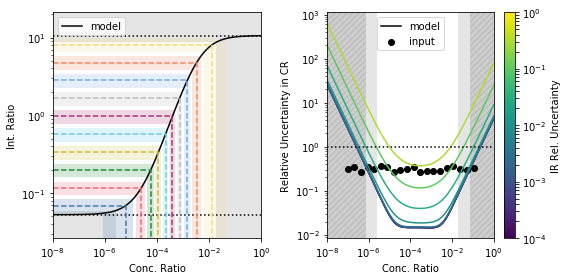

In [14]:
d_key = '1'

# threshold for plotting uncertainty in asymptotes
asymptote_threshold = 10.    # multiples of st.dev.

debug = False

if True:
    print("PLOTTING UNCERTAINTY CHECK...")
    
    CR = data[d_key]['CR']
    IR = data[d_key]['IR_noise']
    
    # ==================================================
    # generate summary figure
    
    # determine x, y axis limits for axes
    x = CR
    check = np.logical_and(x > 0, ~np.isnan(x))
    x_min, x_max = 10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check])))
    x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    y = intensity_curve(model, x_curve)
    check = np.logical_and(y > 0, ~np.isnan(y))
    y_min, y_max = 10**np.log10(0.5*np.nanmin(y[check])), 10**np.log10(2*np.nanmax(y[check]))
    
    print("mean rel. uncertainty in IR: %0.1E" % (np.mean(np.nanstd(IR, axis=1) / np.nanmean(IR, axis=1))))
    
    print()
    print("lower limits of detection:")
    LLOD = detection_limit(model, cov_matrix, noise=100., I2=500, threshold=3., limit='lower', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, LLOD[key], LLOD[key+"_err"]))
    
    print()
    print("upper limits of detection:") 
    ULOD = detection_limit(model, cov_matrix, noise=100., I1=5000, threshold=3., limit='upper', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, ULOD[key], ULOD[key+"_err"]))
        
    print()
    print("noise detect. range: %0.1f orders mag." % (np.log10(ULOD['noise'])-np.log10(LLOD['noise'])))
    print("model detect. range: %0.1f orders mag." % (np.log10(ULOD['model'])-np.log10(LLOD['model'])))
    
    print()
    print("lower limits of quantitation:")  
    LLOQ = detection_limit(model, cov_matrix, noise=100., I2=500, threshold=10., limit='lower', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, LLOQ[key], LLOQ[key+"_err"]))
        
    print()
    print("upper limits of quantitation:")
    ULOQ = detection_limit(model, cov_matrix, noise=100., I1=5000, threshold=10., limit='upper', return_separate_values=True, debug=debug)
    for key in ['noise', 'model']:
        print("    %s: %0.1E +/- %0.1E" % (key, ULOQ[key], ULOQ[key+"_err"]))
        
        
    print()
    print("noise quant. range: %0.1f orders mag." % (np.log10(ULOQ['noise'])-np.log10(LLOQ['noise'])))
    print("model quant. range: %0.1f orders mag." % (np.log10(ULOQ['model'])-np.log10(LLOQ['model'])))
    
    # start figure
    plt.figure(figsize=(8,4))
    
    # ax1: int. ratio vs conc. ratio
    ax = plt.subplot(121)
    # plot data
    x = CR
    y = np.nanmean(IR, axis=1)
    y_err = np.nanstd(IR, axis=1)
    ### ax.errorbar(x, y, yerr=y_err, fmt='none', c='k', capsize=3)
    ### ax.scatter(x, y, c='k', label='data')
    # plot mean model curve
    x_curve = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    y_curve = intensity_curve(model, x_curve)
    ax.plot(x_curve, y_curve, 'k', label='model')
    
    # plot asymptotes
    ax.axhline(model['FXB'].value, c='k', linestyle=':')
    ax.axhline(model['FXJ_JA'].value, c='k', linestyle=':')
    
    # plot limits of quantitation
    if LLOQ['model'] > 0:
        ax.fill(
            [x_min, x_min, LLOQ['model'], LLOQ['model']],
            [y_min, intensity_curve(model, LLOQ['model']), intensity_curve(model, LLOQ['model']), y_min],
            color='k', alpha=0.1, linewidth=0.
        )
    if ULOQ['model'] > 0:
        ax.fill(
            [x_min, x_min, x_max, x_max, ULOQ['model'], ULOQ['model']],
            [intensity_curve(model, ULOQ['model']), y_max, y_max, y_min, y_min, intensity_curve(model, ULOQ['model'])],
            color='k', alpha=0.1, linewidth=0.
        )
    
    # plot test ranges
    IR_tests = np.logspace(np.log10(np.nanmin(y_curve)), np.log10(np.nanmax(y_curve)), 21)[1:-1:2]
    for IR_test, colour in zip(IR_tests, Colour_List):
        IR_err = 0.2 *IR_test
        IR_test_low, IR_test_high = IR_test - IR_err, IR_test + IR_err
        CR_pred, CR_err = predict_concentration(IR_test, IR_err, params=model, cov_matrix=cov_matrix)
        CR_pred_low, CR_low_err = predict_concentration(IR_test_low, 0., params=model, cov_matrix=cov_matrix)
        CR_pred_high, CR_high_err = predict_concentration(IR_test_high, 0., params=model, cov_matrix=cov_matrix)

        ax.plot([x_min, CR_pred, CR_pred], [IR_test, IR_test, y_min], colour, linestyle='--')
        ax.fill(
            [x_min, x_min, CR_pred_high, CR_pred_high, CR_pred_low, CR_pred_low],
            [IR_test_low, IR_test_high, IR_test_high, y_min, y_min, IR_test_low],
            color=colour, alpha=0.2, linewidth=0.
        )
        ### ax.axvspan(CR_pred_low, CR_pred_high, color=colour, alpha=0.2, linewidth=0.)
        if debug == True:
            print()
            print("input IR: %0.1E +/- %0.1E (%3.2f%%)" % (IR_test, IR_err, 100.*IR_err/IR_test))
            print("   range: %0.1E - %0.1E" % (IR_test_low, IR_test_high))
            print("pred CR: %0.1E +/- %0.1E (%3.2f%%)" % (CR_pred, CR_err, 100.*CR_err/CR_pred))
            print("   error range:  %0.1E - %0.1E" % (CR_pred-CR_err, CR_pred+CR_err))
            print("   actual range: %0.1E - %0.1E" % (CR_pred_low, CR_pred_high))
        
    # finish ax
    ax.set_xlabel("Conc. Ratio")
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylabel("Int. Ratio")
    ax.set_ylim(y_min, y_max)
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    ax.minorticks_on()
    
    # ax2: relative uncertainties
    ax = plt.subplot(122)
    
    # plot rel. uncert. of training IR data
    ax.scatter(CR, np.nanstd(IR, axis=1) / np.nanmean(IR, axis=1), c='k', label='input')
    
    # plot rel. uncert. of CR prediction
    factors = [0.0001, 0.00032, 0.001, 0.0032, 0.01, 0.032, 0.1, 0.32]
    norm = mpl.colors.LogNorm(vmin=10**np.floor(np.nanmin(np.log10(factors))), vmax=10**np.ceil(np.nanmax(np.log10(factors))))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
    cmap.set_array([])
    CR_test = np.logspace(np.log10(x_min), np.log10(x_max), 100)
    IR_test = intensity_curve(model, CR_test)
    CR_pred, CR_pred_err = predict_concentration(IR_test, np.zeros_like(IR_test), params=model, cov_matrix=cov_matrix)
    ax.plot(CR_test, CR_pred_err/CR_pred, c='k', label='model')
    for factor in factors:
        IR_err = factor * IR_test
        CR_pred, CR_pred_err = predict_concentration(IR_test, IR_err, params=model, cov_matrix=cov_matrix)
        ax.plot(CR_test, CR_pred_err/CR_pred, c=cmap.to_rgba(factor))
        
    # plot failure line
    ax.axhline(1., linestyle=':', c='k')
    
    # plot limits of detection
    if LLOD['model'] > 0:
        ax.axvspan(x_min, LLOD['model'], color='k', hatch='////', linewidth=0., alpha=0.1)
    if ULOD['model'] > 0:
        ax.axvspan(ULOD['model'], x_max, color='k', hatch='////', linewidth=0., alpha=0.1)
        
    # plot limits of detection
    if LLOQ['model'] > 0:
        ax.axvspan(x_min, LLOQ['model'], color='k', linewidth=0., alpha=0.1)
    if ULOQ['model'] > 0:
        ax.axvspan(ULOQ['model'], x_max, color='k', linewidth=0., alpha=0.1)
    
    # finish ax
    ax.set_xlabel("Conc. Ratio")
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylabel("Relative Uncertainty in CR")
    ax.set_yscale('log')
    ax.legend(loc='upper center')
    plt.colorbar(cmap, ax=ax, label="IR Rel. Uncertainty")
    
    # finish figure
    plt.tight_layout()
    plt.savefig("%smodel-uncertainty_scenario%s.png" % (Fig_dir, Scenario), dpi=300)
    plt.show()
    

## Test Predictions

PREDICTING CONCENTRATIONS FOR RANDOM TEST DATA

generating test spectra
generated data array: (1000, 1) (1000, 1)
input arrays: (1000,) (1000,)
prediction array: (1000,)
    mean rel. error: 0.10%


/Users/joby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log10


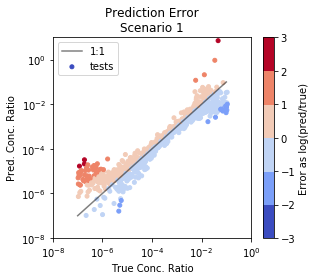

In [6]:
skip = False

debug = False

# number of random test samples to evaluate
test_samples = 1000

# number of measurements per test sample
n_values = 1

# set up range for CA parameter
cmin = -5
cmax = 1
    
if skip == True:
    print("SKIPPING PREDICTION TEST")
else:
    print("PREDICTING CONCENTRATIONS FOR RANDOM TEST DATA")
    d_key = 'test'

    print()
    print("generating test spectra")

    rng = np.random.default_rng(626)

    # generate random concentrations (in ppm)
    CA_test = 10**(np.sort(rng.random(test_samples) * (np.log10(C_max) - np.log10(C_min)) + np.log10(C_min)))
    CB_test = 1000000. - CA_test
    CR_test = CA_test / CB_test
    truths = CR_test
    
    # generate intensity data
    data[d_key] = generate_data(CA_test, CB_test, Params, n_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                            rng_seed=Seed, return_all=True)
    data[d_key]['truths'] = Truths
    
    # predict concentrations from intensities
    x_key = 'CR'
    y_key = 'IR_noise'
    # get data
    x = data[d_key][x_key]
    y = data[d_key][y_key]
    if y.ndim == 2:
        # reduce data to 1D if needed
        y_err = np.nanstd(y, axis=1)
        y = np.nanmean(y, axis=1)
    else:
        y_err = np.zeros_like(y)
    print("input arrays:", np.shape(x), np.shape(y))
    predictions, prediction_errs = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix)
    print("prediction array:", np.shape(predictions))
    data[d_key]['CR_pred'] = predictions
    data[d_key]['CR_pred_err'] = prediction_errs
    
    # check all results are positive
    clean_check = np.logical_and(truths > 0, predictions > 0)
    print("    mean rel. error: %3.2f%%" % (np.nanmean(prediction_errs[clean_check]/predictions[clean_check])))
    
    if debug == True:
        print()
        print("Predicted concentration vs truth: original data")
        for prediction, truth, int_ratio in zip(predictions, truths, IR):
            print("IR=%0.1E: %0.1E vs %0.1E (%0.10f%%)" % (int_ratio, prediction, truth, 100.*(prediction-truth)/truth))
            
    # determine colour mapping for errors in log space
    magnitude_errs = np.log10(predictions) - np.log10(truths)
    vmax = np.ceil(np.abs(np.nanmax(magnitude_errs)))
    norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(-vmax, vmax, 2*int(vmax)+1), ncolors=256)
    error_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    error_cmap.set_array([])

    # print error vs intensity ratio
    plt.figure(figsize=(4.5,4))
    # plot absolute error (in log space)
    """ax = plt.subplot(121)
    ax.set_title("Scenario %s Testing" % Scenario)
    x_key = 'IR_noise'
    y_keys = ['CR', 'CR_pred']
    y_labels = ['Truth', 'Predicted']
    x = data[d_key][x_key]
    y = np.asarray([data[d_key][key] for key in y_keys])
    print(np.shape(y))
    for i in range(len(y_keys)):
        ax.scatter(x, y[i], c=Colour_List[2+i], label=y_labels[i], zorder=2+0.1*i)
    ax.set_xlabel("Int. Ratio")
    check = np.logical_and(x > 0, ~np.isnan(x))
    ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
    ax.set_xscale('log')
    ax.set_ylabel("Conc. Ratio")
    check = np.logical_and(y > 0, ~np.isnan(y))
    ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
    ax.set_yscale('log')
    ax.legend()
    ax.minorticks_on()"""
    # plot relative error
    ax = plt.subplot(111)
    ax.set_title("Prediction Error\nScenario %s" % Scenario)
    # plot perfect 1:1 line
    ax.plot([10**(cmin-2), 10**(cmax-2)], [10**(cmin-2), 10**(cmax-2)], 'k', label='1:1', alpha=0.5)
    # plot predictions vs truth
    x = truths
    y = predictions
    ax.scatter(x, y, c=error_cmap.to_rgba(magnitude_errs), s=16, label='tests')
    ax.set_xlabel("True Conc. Ratio")
    check = np.logical_and(x > 0, ~np.isnan(x))
    ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
    ax.set_xscale('log')
    ax.set_ylabel("Pred. Conc. Ratio")
    check = np.logical_and(y > 0, ~np.isnan(y))
    ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
    ax.set_yscale('log')
    ax.legend()
    ax.minorticks_on()
    plt.colorbar(error_cmap, label="Error as log(pred/true)")
    plt.tight_layout()
    plt.savefig("%spredicted_concentration_error.png" % Fig_dir, dpi=300)
    plt.show()

# Compare Scenarios 1-4

In [7]:
# skip this section?
skip = True

# print debug messages?
debug = True

# plot true parameter values as lines?
plot_truths = True

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

# set up data storage dictionary
data = {}

if skip == True:
    print("SKIPPING SCENARIO COMPARISON")
else:
    print("COMPARING SCENARIO DATASETS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA

    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(121)
    ax1.set_title("Scenario Comparison")
    ax2 = plt.subplot(122)
    temp1 = []
    temp2 = []

    for scenario in [1,2,3,4]:
        print()
        print("plotting scenario %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario

        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,   # raman cross-section for B, v1
            'J_B2': 0.02,    # raman cross-section for B, v2
            'X_v1': 1.,       # sample attenuation factor at v1
            'X_v2': 1.        # sample attenuation factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1']/params['F_v2'],
                                     params['X_v1']/params['X_v2'],
                                     params['J_A1'] / params['J_B2'],
                                     params['J_A2'] / params['J_A1'],
                                     params['J_B1'] / params['J_B2'])

        print()
        print("input data parameters")
        for key, val in truths.items():
            print("%6s: %0.1E" % (key, val))

        # ==================================================
        # generate dataset

        data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                                    rng_seed=Seed+100*scenario, return_all=True)

        # ==================================================
        # create summary figure for this dataset

        # plot intensity ratio vs concentration ratio
        x_key = 'CR'
        y_keys = ['IR_noise']
        x = data[d_key][x_key]
        y = np.asarray([np.nanmean(data[d_key][key], axis=1) for key in y_keys])
        y_err = np.asarray([np.nanstd(data[d_key][key], axis=1) for key in y_keys])
        for i, key in enumerate(y_keys):
            # plot intensity ratio in ax1
            ax1.scatter(x, y[i], c=Colour_List[scenario], label="scen. %s" % scenario, zorder=2+0.1*i)
            temp1.append(y[i])
            # plot d(IR)/d(CR) in ax2
            ax2.scatter(x, np.gradient(y[i], x), c=Colour_List[scenario], label="scen. %s" % scenario, zorder=2+0.1*i)
            temp2 = np.diff(y[i])/np.diff(x)
            print(temp2)
    ax1.set_xlabel("Concentration Ratio")
    check = np.logical_and(x > 0, ~np.isnan(x))
    # ax1.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
    # ax1.set_xscale('log')
    ax1.set_ylabel("Sim. Intensity Ratio")
    # ax2.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
    # ax2.set_xscale('log')
    ax2.set_ylabel("Int. Ratio Gradient")
    y = np.concatenate(temp1)
    check = np.logical_and(y > 0, ~np.isnan(y))
    # ax1.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
    # ax1.set_yscale('log')
    ax1.legend()
    ax2.legend()

    # finish figure
    plt.tight_layout()
    if save_plot == True:
        plt.savefig("%ssim_dataset_scenario-comparison.png" % (Fig_dir), dpi=300)
    if show_plot == True:
        plt.show()
    else:
        plt.close()

SKIPPING SCENARIO COMPARISON


In [8]:
if skip == True:
    print("SKIPPING SCENARIO FIT COMPARISON")
else:
    print("COMPARING SCENARIO FITS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    models = []
    cov_matrices = []

    for scenario in [1,2,3,4]:
        print()
        print("fitting scenario %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario
        
        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,   # raman cross-section for B, v1
            'J_B2': 0.02,    # raman cross-section for B, v2
            'X_v1': 1.,       # sample attenuation factor at v1
            'X_v2': 1.        # sample attenuation factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.

        truths = get_true_parameters(params['F_v1']/params['F_v2'], params['X_v1']/params['X_v2'],
                                     params['J_A1'] / params['J_B2'], params['J_A2'] / params['J_A1'], params['J_B1'] / params['J_B2'])

        if scenario == 1:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        elif scenario == 2:
            x_lims = {'FXJ': (2000,3000), 'FXB': (0.03, 0.07), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        elif scenario == 3:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (150, 350), 'FXJ_JA': (None, None)}
        else:
            x_lims = {'FXJ': (2000,3000), 'FXB': (-0.0001, 0.0001), 'JA': (-1, 2), 'FXJ_JA': (None, None)}
        
        print()
        print("input data parameters")
        for key, val in truths.items():
            print("%6s: %0.1E" % (key, val))

        # ==================================================
        # generate dataset

        data[d_key] = generate_data(CA, CB, params, N_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                                    rng_seed=Seed+100*scenario, return_all=True)
        data[d_key]['truths'] = truths
        data[d_key]['x_lims'] = x_lims
        
        # ==================================================
        # fit model to this dataset
        
        x_key = 'CR'
        y_key = 'IR_noise'
        if N_values > 1 and Bootstrap == True:
            # get data
            x = data[d_key][x_key]
            y = data[d_key][y_key]
            print("input arrays:", np.shape(x), np.shape(y))
            # fit models using bootstrap method
            model, cov_matrix, bootstrap_results = bootstrap_intensity_fit_script(x, y, truths=truths, x_lims=x_lims,
                                        show_plot=show_plot, save_plot=save_plot, fig_dir=Fig_dir, debug=True)
            
            cov_matrices.append(cov_matrix)
            
        else:
            # get data
            x = data[d_key][x_key]
            y = data[d_key][y_key]
            if y.ndim == 2:
                # reduce data to 1D if needed
                y = np.nanmean(y, axis=1)
            print("input arrays:", np.shape(x), np.shape(y))
            # fit model to data
            model = intensity_fit_script(x, y, debug=True)
            
        models.append(model)
            
        # report fitted parameter values
        print()
        for key in ['FXJ', 'FXB', 'JA']:
            # report results for each parameter
            print("    %s:" % key)
            print("       truth: %+0.1E" % data[d_key]['truths'][key])
            if N_values > 1 and Bootstrap == True:
                print("        mean: %+0.1E" % model[key].value)
                print("      median: %+0.1E" % np.median(bootstrap_results[key]))
                print("       stdev: %+0.1E (%3.3f%%)" % (model[key].stderr, 100*model[key].relerr))
                print("       range: %+0.1E - %0.1E" % (np.nanmin(bootstrap_results[key]), np.nanmax(bootstrap_results[key])))
            else:
                print("       value: %+0.1E" % model[key].value)
            print("     rel err: %+3.1E" % (model[key].value/data[d_key]['truths'][key]-1))

SKIPPING SCENARIO FIT COMPARISON


In [9]:
if skip == True:
    print("SKIPPING SCENARIO FIT COMPARISON")
else:
    print("COMPARING SCENARIO FITS")

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA

    for scenario, model, cov_matrix in zip([1,2,3,4], models, cov_matrices):
        print()
        print("scenario %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario
        
        # report fitted parameter values
        print()
        for key in ['FXJ', 'FXB', 'JA']:
            # report results for each parameter
            print("    %s:" % key)
            print("       truth: %+0.1E" % data[d_key]['truths'][key])
            if N_values > 1 and Bootstrap == True:
                print("        mean: %+0.1E" % model[key].value)
                print("      median: %+0.1E" % np.median(bootstrap_results[key]))
                print("       stdev: %+0.1E (%3.3f%%)" % (model[key].stderr, 100*model[key].relerr))
                print("       range: %+0.1E - %0.1E" % (np.nanmin(bootstrap_results[key]), np.nanmax(bootstrap_results[key])))
            else:
                print("       value: %+0.1E" % model[key].value)
            print("     rel err v truth: %+3.E" % (model[key].value/data[d_key]['truths'][key]-1))
            
        # ==================================================
        # create summary figure for this model
        
        plt.figure(figsize=(8,4))
        # 1st ax: datapoints and fitted model
        ax = plt.subplot(121)
        
        # plot training data
        x_key = 'CR'
        y_keys = ['IR_noise']
        x = data[d_key][x_key]
        y = np.nanmean(data[d_key][y_key], axis=1)
        y_err = np.nanstd(data[d_key][y_key], axis=1)
        print(np.shape(x), np.shape(y), np.shape(y_err))
        ax.errorbar(x, y, yerr=y_err, fmt='none', ecolor=Colour_List[2], capsize=3, zorder=2)
        ax.scatter(x, y, c=Colour_List[2], label="data", zorder=2)
        
        # plot fitted model
        x_curve = np.logspace(np.floor(np.log10(0.9*C_min)-6), np.ceil(np.log10(1.1*C_max)-6), 100)
        y_curve = intensity_curve(model, x_curve)
        ax.plot(x_curve, y_curve, 'k:', label="fit", zorder=1.5)
        
        # plot confidence interval for model
        pred, err = predict_intensity(x_curve, model, cov_matrix)
        ax.fill_between(x_curve, pred-err, pred+err, linewidth=0., fc='k', zorder=1)
        ax.plot(x_curve, pred, 'k', zorder=2.5)
        
        # finish subplot
        ax.set_title("Scenario %s" % scenario)
        ax.set_xlabel("Concentration Ratio")
        check = np.logical_and(x > 0, ~np.isnan(x))
        ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
        ax.set_xscale('log')
        ax.set_ylabel("Sim. Intensity Ratio")
        check = np.logical_and(y > 0, ~np.isnan(y))
        ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
        ax.set_yscale('log')
        ax.legend(loc='lower right')
        
        # add fitted parameter values
        xo, yo, w, h = (0.12, 0.92, 0.25, 0.06)
        ax.text(xo+1*w, yo+h, 'true', ha='right', va='top', transform=ax.transAxes)
        ax.text(xo+2*w, yo+h, 'fit', ha='right', va='top', transform=ax.transAxes)
        for i, key in enumerate(['FXJ', 'FXB', 'JA']):
            ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform = ax.transAxes)
            ax.text(xo+1*w, yo-i*h, "%0.1E" % data[d_key]['truths'][key], ha='right', va='top', transform = ax.transAxes)
            ax.text(xo+2*w, yo-i*h, "%0.1E" % model[key].value, ha='right', va='top', transform = ax.transAxes)

        # 2nd ax: relative error in predicted concentration
        ax = plt.subplot(122)
        
        # plot predictions vs truth for all input datapoints
        truth = data[d_key]['CR']
        y = data[d_key]['IR_noise']
        y_err = np.zeros_like(y)
        print(np.shape(truth), np.shape(y), np.shape(y_err))
        for true, iy, iy_err in zip(truth, y, y_err):
            prediction, error = predict_concentration(iy, iy_err, params=model, cov_matrix=cov_matrix, debug=False)
            ax.scatter(np.full_like(iy, true), prediction/true, c='k', zorder=1., alpha=1./np.sqrt(np.size(iy)))
        
        # plot predictions vs truth for mean input datapoints
        truth = data[d_key]['CR']
        y = np.nanmean(data[d_key]['IR_noise'], axis=1)
        y_err = np.nanstd(data[d_key]['IR_noise'], axis=1)
        prediction, error = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix, debug=True)
        clean_check = np.logical_and(truth > 0, prediction > 0)
        ax.errorbar(truth, prediction/truth, yerr=error/truth, fmt='none', ecolor=Colour_List[4], capsize=3, zorder=2)
        ax.scatter(truth, prediction/truth, c='r', zorder=2)
        
        print("    input IR mean rel. error: %3.2f%%" % (100.*np.nanmean(y_err/y)))
        print("    pred. CR mean rel. error: %3.2f%%" % (100.*np.nanmean(error[clean_check]/prediction[clean_check])))
        for true, pred, err in zip(truth, prediction, error):
            print("        truth = %0.1E, pred = %0.1E +/- %0.1E" % (true, pred, err))
        
        # add ideal line
        ax.axhline(1., c='k', linestyle=':')
            
        # finish subplot
        x = truth
        y = prediction / truth
        ax.set_xlabel("Concentration Ratio")
        check = np.logical_and(x > 0, ~np.isnan(x))
        ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
        ax.set_xscale('log')
        ax.set_ylabel("Prediction/Truth")
        check = np.logical_and(y > 0, ~np.isnan(y))
        ax.set_ylim(10**np.floor(np.log10(np.nanmin(y[check]))), 10**np.ceil(np.log10(np.nanmax(y[check]))))
        ax.set_yscale('log')

        # finish figure
        plt.tight_layout()
        if save_plot == True:
            plt.savefig("%ssim_dataset_scenario%s.png" % (Fig_dir, Scenario), dpi=300)
        if show_plot == True:
            plt.show()
        else:
            plt.close()

    # ==================================================
    # create summary figure for all models
    
    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    
    for ax, scenario, model in zip(axs.flat, [1,2,3,4], models):
        # for each model
        print()
        print("plotting scenario %s" % scenario)
        # key for this dataset
        d_key = 'scenario %s' % scenario
        
        x_key = 'CR'
        y_key = 'IR_noise'
        if N_values > 1 and Bootstrap == True:
            x = data[d_key][x_key]
            y = data[d_key][y_key]
        else:
            x = data[d_key][x_key]
            y = data[d_key][y_key]
            y_err = np.full_like(y, np.nan)
            if y.ndim == 2:
                y_err = np.nanstd(y, axis=1)
                y = np.nanmean(y, axis=1)

        # plot training data
        x_key = 'CR'
        y_keys = 'IR_noise'
        x = data[d_key][x_key]
        y = np.nanmean(data[d_key][y_key], axis=1)
        y_err = np.nanstd(data[d_key][y_key], axis=1)
        ax.errorbar(x, y, yerr=y_err, fmt='none', ecolor=Colour_List[2], capsize=3, zorder=2)
        ax.scatter(x, y, c=Colour_List[2], label="data", zorder=2)
        
        # plot fitted model
        x_curve = np.logspace(np.floor(np.log10(0.9*C_min)-6), np.ceil(np.log10(1.1*C_max)-6), 100)
        y_curve = intensity_curve(model, x_curve)
        ax.plot(x_curve, y_curve, 'k:', label="fit", zorder=1.5)
            
        # set axis limits for subplot
        ax.set_title("Scenario %s" % scenario)
        ax.set_xlabel("Concentration Ratio")
        check = np.logical_and(x > 0, ~np.isnan(x))
        ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
        ax.set_xscale('log')
        ax.set_ylabel("Sim. Intensity Ratio")
        check = np.logical_and(y > 0, ~np.isnan(y))
        ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
        ax.set_yscale('log')
        
        # add fitted parameter values
        xo, yo, w, h = (0.12, 0.92, 0.25, 0.06)
        ax.text(xo+1*w, yo+h, 'true', ha='right', va='top', transform=ax.transAxes)
        ax.text(xo+2*w, yo+h, 'fit', ha='right', va='top', transform=ax.transAxes)
        for i, key in enumerate(['FXJ', 'FXB', 'JA']):
            ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform = ax.transAxes)
            ax.text(xo+1*w, yo-i*h, "%0.1E" % data[d_key]['truths'][key], ha='right', va='top', transform = ax.transAxes)
            ax.text(xo+2*w, yo-i*h, "%0.1E" % model[key].value, ha='right', va='top', transform = ax.transAxes)
        
        ax.legend(loc='lower right')

    # finish figure
    fig.tight_layout()
    fig.savefig("%ssim_fitted_scenario-comparison.png" % (Fig_dir), dpi=300)
    fig.show()

SKIPPING SCENARIO FIT COMPARISON


In [10]:
# number of test concentrations to evaluate
n_concs = 20

# number of samples per test concentration
n_samples = 1000

# number of measurements per test sample
n_values = 1

# set up range for CA parameter
cmin = -5
cmax = 1
    
if skip == True:
    print("SKIPPING PREDICTION TEST COMPARISON")
else:
    print("PREDICTING CONCENTRATIONS FOR RANDOM TEST DATA")

    print()
    print("generating test spectra")

    rng = np.random.default_rng(626)

    # generate random concentrations (in ppm)
    ### CA_test = 10**(np.sort(rng.random(n_concs) * (np.log10(C_max) - np.log10(C_min)) + np.log10(C_min)))
    CA_test = np.repeat(np.logspace(np.log10(C_min), np.log10(C_max), n_concs), n_samples)
    CB_test = 1000000. - CA_test
    CR_test = CA_test / CB_test
    truths = CR_test
    
    for scenario, model, cov_matrix in zip([1,2,3,4], models, cov_matrices):
        d_key = 'scenario %s test' % scenario
        
        # ==================================================
        # define parameters

        params = {
            'I_v0': 1.,       # incident laser intensity
            'F_v1': 1.,       # instrument sensitivity factor at v1
            'F_v2': 1.,       # instrument sensitivity factor at v2
            'J_A1': 50.,      # raman cross-section for A, v1
            'J_A2': 5.,       # raman cross-section for A, v2
            'J_B1': 0.001,   # raman cross-section for B, v1
            'J_B2': 0.02,    # raman cross-section for B, v2
            'X_v1': 1.,       # sample attenuation factor at v1
            'X_v2': 1.        # sample attenuation factor at v2
        }

        if scenario in [2,4]:
            params['J_A2'] = 0.
        if scenario in [3,4]:
            params['J_B1'] = 0.
        
        # generate ideal test data
        temp = np.logspace(np.log10(C_min), np.log10(C_max), 1000)
        print("generating ideal data for scenario %s" % scenario)
        data[d_key+"ideal"] = generate_data(temp, 1000000. - temp, params, 1, dark_noise=0., shot_noise=0.,
                                rng_seed=Seed, return_all=True, debug=True)
        
        
        # predict concentrations from clean intensities
        x_key = 'CR'
        y_key = 'IR_clean'
        # get data
        x = data[d_key+"ideal"][x_key]
        y = data[d_key+"ideal"][y_key]
        if y.ndim == 2:
            # reduce data to 1D if needed
            y_err = np.nanstd(y, axis=1)
            y = np.nanmean(y, axis=1)
        else:
            y_err = np.zeros_like(y)
        print("input arrays for test prediction:", np.shape(x), np.shape(y))
        truths = CR_test
        predictions, prediction_errs = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix)
        print("    prediction array:", np.shape(predictions))
        data[d_key+"ideal"]['CR_pred'] = predictions
        data[d_key+"ideal"]['CR_pred_err'] = prediction_errs
        
        # generate noisy test data
        print("generating noisy data for scenario %s" % scenario)
        data[d_key] = generate_data(CA_test, CB_test, params, n_values, dark_noise=Dark_Noise, shot_noise=Shot_Noise,
                                rng_seed=Seed, return_all=True, debug=True)
        
        # predict concentrations from noisy intensities
        x_key = 'CR'
        y_key = 'IR_noise'
        # get data
        x = data[d_key][x_key]
        y = data[d_key][y_key]
        if y.ndim == 2:
            # reduce data to 1D if needed
            y_err = np.nanstd(y, axis=1)
            y = np.nanmean(y, axis=1)
        else:
            y_err = np.zeros_like(y)
        print("input arrays for test prediction:", np.shape(x), np.shape(y))
        truths = CR_test
        predictions, prediction_errs = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix)
        print("prediction array:", np.shape(predictions))
        data[d_key]['CR_pred'] = predictions
        data[d_key]['CR_pred_err'] = prediction_errs
        
        # determine colour mapping for errors in log space
        magnitude_errs = np.log10(predictions) - np.log10(truths)
        vmax = np.ceil(np.abs(np.nanmax(magnitude_errs)))
        norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(-vmax, vmax, 2*int(vmax)+1), ncolors=256)
        error_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
        error_cmap.set_array([])

        # print error vs intensity ratio
        plt.figure(figsize=(9,4))
        # plot absolute error (in log space)
        ax = plt.subplot(121)
        ax.set_title("Testing\nScenario %s" % scenario)
        x_key = 'IR_noise'
        y_keys = ['CR', 'CR_pred']
        y_labels = ['Truth', 'Predicted']
        x = data[d_key][x_key]
        y = np.asarray([data[d_key][key] for key in y_keys])
        print(np.shape(y))
        for i in range(len(y_keys)):
            ax.scatter(x, y[i], c=Colour_List[2+i], label=y_labels[i], zorder=2+0.1*i)
        ax.set_xlabel("Int. Ratio")
        check = np.logical_and(x > 0, ~np.isnan(x))
        ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
        ax.set_xscale('log')
        ax.set_ylabel("Conc. Ratio")
        check = np.logical_and(y > 0, ~np.isnan(y))
        ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
        ax.set_yscale('log')
        ax.legend()
        ax.minorticks_on()
        # plot relative error
        ax = plt.subplot(122)
        ax.set_title("Prediction Error\nScenario %s" % scenario)
        # plot perfect 1:1 line
        ax.plot([10**(cmin-2), 10**(cmax-2)], [10**(cmin-2), 10**(cmax-2)], 'k', label='1:1', alpha=0.5)
        # plot predictions vs truth
        x = truths
        y = predictions
        ax.scatter(x, y, c=error_cmap.to_rgba(magnitude_errs), s=16, alpha=1./np.sqrt(n_samples), label='tests')
        ax.set_xlabel("True Conc. Ratio")
        check = np.logical_and(x > 0, ~np.isnan(x))
        ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
        ax.set_xscale('log')
        ax.set_ylabel("Pred. Conc. Ratio")
        check = np.logical_and(y > 0, ~np.isnan(y))
        ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
        ax.set_yscale('log')
        ax.legend()
        ax.minorticks_on()
        plt.colorbar(error_cmap, label="Error as log(pred/true)")
        plt.tight_layout()
        plt.savefig("%spredicted_concentration_error.png" % Fig_dir, dpi=300)
        plt.show()
    
    # ==================================================
    # create summary figure for all models
    
    # determine colour mapping for errors in log space, across all axes
    truths = np.concatenate([data['scenario %s test' % scenario]['CR'] for scenario in [1,2,3,4]])
    predictions = np.concatenate([data['scenario %s test' % scenario]['CR_pred'] for scenario in [1,2,3,4]])
    magnitude_errs = np.log10(predictions) - np.log10(truths)
    vmax = np.ceil(np.nanmax(np.abs(magnitude_errs)))
    norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(-vmax, vmax, 2*int(vmax)+1), ncolors=256)
    error_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    error_cmap.set_array([])
    
    # determine x, y axis limits for all axes
    x = truths
    y = predictions/truths
    check = np.logical_and(x > 0, ~np.isnan(x))
    x_min, x_max = 10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check])))
    check = np.logical_and(y > 0, ~np.isnan(y))
    y_min, y_max = 10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check])))
    
    fig, axs = plt.subplots(2, 2, figsize=(9,8))
    
    for ax, scenario, model, cov_matrix in zip(axs.flat, [1,2,3,4], models, cov_matrices):
        d_key = 'scenario %s test' % scenario
        
        truths = data[d_key]['CR']
        predictions = data[d_key]['CR_pred']
        prediction_errs = data[d_key]['CR_pred_err']
        
        # check all results are positive
        clean_check = np.logical_and(truths > 0, predictions > 0)
        
        # plot relative error
        ax.set_title("Scenario %s" % scenario)
        # plot perfect 1:1 line
        ### ax.plot([10**(cmin-2), 10**(cmax-2)], [10**(cmin-2), 10**(cmax-2)], 'r', label='1:1', alpha=1., zorder=3)
        ax.axhline(1., c='r', label='1:1', alpha=1., zorder=3)
        # plot predictions vs truth for noisy data
        x = truths
        y = predictions/truths
        mag_err = np.log10(predictions) - np.log10(truths)
        ax.scatter(x, y, c='k', s=16, alpha=1./np.sqrt(n_samples), label='tests')
        # plot predictions vs truth for ideal data
        x = data[d_key+"ideal"]['CR']
        y = data[d_key+"ideal"]['CR_pred']/x
        ax.plot(x, y, c='b', label='ideal', zorder=4)
        ax.set_xlabel("True Conc. Ratio")
        ax.set_xlim(x_min, x_max)
        ax.set_xscale('log')
        ax.set_ylabel("Pred./True Conc. Ratio")
        ax.set_ylim(y_min, y_max)
        ax.set_yscale('log')
        ax.legend(loc='upper left')
        ax.minorticks_on()
        ### fig.colorbar(error_cmap, ax=ax, label="Error in orders mag.")
    fig.tight_layout()
    fig.savefig("%spredicted_concentration_error_comparison.png" % Fig_dir, dpi=300)
    fig.show()
    
    # ==================================================
    # create summary figure for each model/test
    
    # determine x, y axis limits for each axes
    x = np.concatenate([data['scenario %s' % scenario]['CR'] for scenario in [1,2,3,4]])
    check = np.logical_and(x > 0, ~np.isnan(x))
    x_min, x_max = 10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check])))
    y = np.concatenate([data['scenario %s' % scenario]['IR_noise'] for scenario in [1,2,3,4]])
    check = np.logical_and(y > 0, ~np.isnan(y))
    y1_min, y1_max = 10**np.floor(np.log10(np.nanmin(y[check]))), 10**np.ceil(np.log10(np.nanmax(y[check])))
    
    y = np.concatenate([data['scenario %s test' % scenario]['IR_noise'] for scenario in [1,2,3,4]])
    check = np.logical_and(y > 0, ~np.isnan(y))
    y2_min, y2_max = 10**np.floor(np.log10(np.nanmin(y[check]))), 10**np.ceil(np.log10(np.nanmax(y[check])))
    
    x = np.concatenate([data['scenario %s test' % scenario]['CR'] for scenario in [1,2,3,4]])
    y = np.concatenate([data['scenario %s test' % scenario]['CR_pred'] for scenario in [1,2,3,4]]) / x
    check = np.logical_and(y > 0, ~np.isnan(y))
    y = np.log10(y[check])
    y3_min, y3_max = np.floor(np.sort(y)[int(0.01*len(y))]), np.ceil(np.sort(y)[int(0.99*len(y))])
    
    for scenario, model, cov_matrix in zip([1,2,3,4], models, cov_matrices):
        d_key = 'scenario %s test' % scenario
        
        # get test data
        unique_CRs = np.unique(CR_test)
        temp1 = []
        temp2 = []
        for i, cr in enumerate(unique_CRs):
            # for each unique concentration in dataset
            result = np.ravel(np.where(data[d_key]['CR'] == cr))
            
            # get data for ax1 (intensity ratio)
            x = data[d_key]['CR'][result]
            y = data[d_key]['IR_noise'][result]
            if y.ndim > 1:
                y = np.nanmean(y, axis=1)
            check = np.logical_and(x > 0, y > 0)
            temp1.append(np.sort(y[check]))
            
            # get data for ax2 (log (pred/true) conc. ratio)
            y = data[d_key]['CR_pred'][result] / x
            if y.ndim > 1:
                y = np.nanmean(y, axis=1)
            check = np.logical_and(x > 0, y > 0)
            temp2.append(np.log10(np.sort(y[check])))
            
        # set up figure
        fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True)
        ax1, ax2, ax3 = axs.flat
        
        # ax1: training dataset and model curves
        ax1.set_title("Scenario %s\nModel Training" % scenario)
        # plot training data
        x = data['scenario %s' % scenario]['CR']
        y = data['scenario %s' % scenario]['IR_noise']
        if y.ndim > 1:
            y_err = np.nanstd(y, axis=1)
            y = np.nanmean(y, axis=1)
            ax1.errorbar(x, y, yerr=y_err, fmt='none', c='k', capsize=3)
        ax1.scatter(x, y, c='k', label='data')
        # plot true curve
        x = np.logspace(np.log10(np.nanmin(x)), np.log10(np.nanmax(x)), 100)
        y = intensity_curve(data['scenario %s' % scenario]['truths'], x)
        ax1.plot(x, y, c='r', linestyle=':', label='truth', zorder=3)
        # plot trained model
        x = np.logspace(np.log10(np.nanmin(x)), np.log10(np.nanmax(x)), 100)
        y = intensity_curve(model, x)
        ax1.plot(x, y, c='b', label='model', zorder=4)
        # finish ax
        ax1.set_xlabel("Conc. Ratio")
        ax1.set_xlim(x_min, x_max)
        ax1.set_xscale('log')
        ax1.set_ylabel("Int. Ratio")
        ax1.set_ylim(y2_min, y2_max)
        ax1.set_yscale('log')
        ax1.legend(loc='upper left')
        ax1.minorticks_on()
        
        # ax2: intensity ratio vs concentration ratio
        ax2.set_title("Scenario %s\nTest Intensities" % scenario)
        # plot spread of test intensity ratios as boxplot
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        ax2.boxplot(temp1, positions=unique_CRs, widths=width(unique_CRs,0.2), patch_artist=True, showfliers=False,
                       medianprops={'color': 'w'},
                       boxprops={'facecolor': 'gainsboro'},
                       flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                  )
        # plot true intensity curve
        x = data[d_key + "ideal"]['CR']
        y = data[d_key + "ideal"]['IR_clean']
        ax2.plot(x, y, c='r', linestyle=':', label='truth', zorder=3)
        # plot model intensity curve
        x = data[d_key + "ideal"]['CR']
        y = intensity_curve(model, x)
        ax2.plot(x, y, c='b', label='model', zorder=4)
        # finish ax
        ax2.set_xlabel("Conc. Ratio")
        ax2.set_xlim(x_min, x_max)
        ax2.set_xscale('log')
        ax2.set_ylabel("Int. Ratio")
        ax2.set_ylim(y2_min, y2_max)
        ax2.set_yscale('log')
        ax2.legend(loc='upper left')
        ax2.minorticks_on()
        
        # ax3: predicted concentration ratio vs truth
        ax3.set_title("Scenario %s\nPredicted Concentrations" % scenario)
        # get data
        # plot reference line for perfect prediction
        ax3.axhline(0., c='r', linestyle=':', label='1:1', alpha=1., zorder=3)
        # plot predictions vs truth for noisy data
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        ax3.boxplot(temp2, positions=unique_CRs, widths=width(unique_CRs,0.2), patch_artist=True, showfliers=False,
                       medianprops={'color': 'w'},
                       boxprops={'facecolor': 'gainsboro'},
                       flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                  )
        # plot predictions vs truth for ideal data
        x = data[d_key+"ideal"]['CR']
        y = data[d_key+"ideal"]['CR_pred']/x
        ax3.plot(x, np.log10(y), c='b', label='ideal', zorder=4)
        # finish ax
        ax3.set_xlabel("True Conc. Ratio")
        ax3.set_xlim(x_min, x_max)
        ax3.set_xscale('log')
        ax3.set_ylabel("Prediction Error (order mag.)")
        ax3.set_ylim(y3_min, y3_max)
        ax3.legend(loc='upper right')
        ax3.minorticks_on()
        ### fig.colorbar(error_cmap, ax=ax, label="Error in orders mag.")
        fig.tight_layout()
        fig.savefig("%smodel-test_scenario%s.png" % (Fig_dir, scenario), dpi=300)
        fig.show()
    
    # ==================================================
    # create boxplot summary figure for all models
    
    unique_CRs = np.unique(CR_test)
    avs = np.zeros((4, len(unique_CRs)))
    stds = np.zeros((4, len(unique_CRs)))
    failures = np.zeros((4, len(unique_CRs)))
    
    fig, axs = plt.subplots(2, 2, figsize=(9,8), sharex=True, sharey=True)
    
    for ax, scenario, model, cov_matrix, av, std, failure in zip(axs.flat, [1,2,3,4], models, cov_matrices, avs, stds, failures):
        d_key = 'scenario %s test' % scenario
        
        print()
        print(d_key)
        temp = []
        for i, cr in enumerate(unique_CRs):
            result = np.ravel(np.where(CR_test == cr))
            
            truths = data[d_key]['CR'][result]
            predictions = data[d_key]['CR_pred'][result]
            
            x = cr
            y = predictions / truths
            
            check = np.logical_and(predictions > 0, truths > 0)
            av[i] = np.nanmedian(y[check])
            std[i] = np.nanstd(y[check])
            failure[i] = np.count_nonzero(predictions <= 0)
            
            ### print("CR = %0.1E, error = %0.1f" % (cr, np.log10(av[i])))
            
            temp.append(np.log10(np.sort(y[check])))
            
        for threshold in [0.01, 0.05, 0.1, 0.5, 1.,]:
            check = np.abs(np.log10(av)) < threshold
            if np.count_nonzero(check) > 1:
                cr_min = unique_CRs[check][0]
                cr_max = unique_CRs[check][-1]
                print("error < %0.2f: %0.1E - %0.1E (%0.1f orders mag.)" % (threshold, cr_min, cr_max, np.log10(cr_max/cr_min)))
            else:
                print("error < %0.2f: not enough data" % (threshold))
        
        # plot predictions vs truth for ideal data
        x = data[d_key + "ideal"]['CR']
        y = data[d_key + "ideal"]['CR_pred']/x
        ax.plot(x, np.log10(y), c='b', label='ideal', zorder=4)
        ax.scatter(unique_CRs, np.log10(av), c='r')
        
        
        # plot spread of predicted concentrations from individual intensities
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        ax.boxplot(temp, positions=unique_CRs, widths=width(unique_CRs,0.2), patch_artist=True, showfliers=False,
                       medianprops={'color': 'w'},
                       boxprops={'facecolor': 'gainsboro'},
                       flierprops={'markersize': 4, 'linewidth': 0, 'markerfacecolor': 'k', 'alpha': 0.2}
                  )
        
        # plot prediction and uncertainty from mean intensities
        for i, cr in enumerate(unique_CRs):
            result = np.ravel(np.where(CR_test == cr))
            y = np.nanmean(data[d_key]['IR_noise'][result])
            y_err = np.nanstd(data[d_key]['IR_noise'][result])
            prediction, error = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix)
            y = np.log10(prediction / cr)
            y_err = np.log10(error / cr)
            label = "_"
            if i == 0:
                label = "mean"
            ax.errorbar(cr, y, yerr=y_err, c='r', fmt='none', capsize=3, zorder=4)
            ax.scatter(cr, y, c='r', label='mean', zorder=5)

        # update y limits
        y_min = np.amin([ax.get_ylim()[0], np.nanmin(np.concatenate(temp))])
        y_max = np.amax([ax.get_ylim()[1], np.nanmax(np.concatenate(temp))])
        ax.set_ylim(y_min, y_max)
        
        ax.set_title("Scenario %s Test" % scenario)
        ax.set_xlabel("True Conc. Ratio")
        ax.set_xlim(x_min, x_max)
        ax.set_xscale('log')
        ax.set_ylabel("Error (order mag.)")
        ### ax.set_ylim(y_min, y_max)
        ### ax.set_yscale('log')
        
        # plot perfect 1:1 result
        ax.axhline(0., color='r', zorder=1.5)
    fig.tight_layout()
    fig.savefig("%spredicted_concentration_error_comparison_boxplot.png" % Fig_dir, dpi=300)
    fig.show()
    
    # ==================================================
    # plot failure rate
    
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    for scenario, failure in zip([1,2,3,4], failures):
        ax.plot(unique_CRs, failure/n_samples, c=Colour_List[scenario-1], label="scen. %s" % scenario)
    ax.set_title("Failure Rate")
    ax.set_xlabel("True Conc. Ratio")
    ax.set_xlim(x_min, x_max)
    ax.set_xscale('log')
    ax.set_ylabel("Failure Rate")
    ax.set_ylim(-0.1, 1)
    ax.axhline(0., linestyle=':', c='k')
    ax.minorticks_on()
    ax.legend()
    plt.tight_layout()
    plt.savefig("%spredicted_concentration_failures.png" % Fig_dir, dpi=300)
    plt.show()

SKIPPING PREDICTION TEST COMPARISON


## Simulate Effects of Noise

In [11]:

skip = True

debug = False

n_darks = [1., 10., 100., 1000.]
n_shots = [0., 0.1, 0.2, 0.3]

if skip == True:
    print("SKIPPING NOISE ANALYSIS")
else:
    print("SIMULATING EFFECTS OF NOISE")
    
    print("dark noise levels to evaluate:", n_darks)
    print("shot noise levels to evaluate:", n_shots)

    # generate input concentrations (in ppm)
    CA = np.logspace(np.log10(C_min), np.log10(C_max), int(C_samples))
    CB = 1000000. - CA
    
    models = []
    
    for i1, dark in enumerate(n_darks):
        models.append([])
        for i2, shot in enumerate(n_shots):
            print()
            print("fitting scenario %s, Nd = %0.1E Ns = %0.1E" % (Scenario, dark, shot))
            # key for this dataset
            d_key = 'N %sx%s' % (i1, i2)
            
            # ==================================================
            # generate dataset

            data[d_key] = generate_data(CA, CB, Params, N_values, dark_noise=dark, shot_noise=shot,
                                        rng_seed=Seed+100*i1+10*i2, return_all=True)
            data[d_key]['truths'] = Truths

            # ==================================================
            # fit model to this dataset

            x_key = 'CR'
            y_key = 'IR_noise'
            if N_values > 1 and Bootstrap == True:
                bootstrapping = True
                # get data
                x = data[d_key][x_key]
                y = data[d_key][y_key]
                y_err = np.zeros_like(y)
                print("input arrays:", np.shape(x), np.shape(y))
                # generate bootstrap data
                y_bootstrap = bootstrap_resample(y, N_Bootstraps, seed=626)
                # fit models to bootstrap
                model, bootstrap_results = bootstrap_intensity_fit_script(x, y_bootstrap, truths=Truths,
                                                        show_plot=False, debug=False)
                
                # reduce data to 1D for plotting
                y_err = np.nanstd(y, axis=1)
                y = np.nanmean(y, axis=1)
            else:
                bootstrapping = False
                # get data
                x = data[d_key][x_key]
                y = data[d_key][y_key]
                if y.ndim == 2:
                    # reduce data to 1D if needed
                    y_err = np.nanstd(y, axis=1)
                    y = np.nanmean(y, axis=1)
                else:
                    y_err = np.zeros_like(y)
                print("input arrays:", np.shape(x), np.shape(y))
                # fit model to data
                model = intensity_fit_script(x, y, show_plot=False, debug=True)

            models[-1].append(model)
            
            # report fitted parameter values
            print()
            for key in ['FXJ', 'FXB', 'JA']:
                # report results for each parameter
                print("    %s:" % key)
                print("       truth: %+0.1E" % data[d_key]['truths'][key])
                if bootstrapping == True:
                    print("        mean: %+0.1E" % model[key].value)
                    print("      median: %+0.1E" % np.median(bootstrap_results[key]))
                    print("       stdev: %+0.1E (%3.3f%%)" % (model[key].stderr, 100*model[key].relerr))
                    print("       range: %+0.1E - %0.1E" % (np.nanmin(bootstrap_results[key]), np.nanmax(bootstrap_results[key])))
                else:
                    print("       value: %+0.1E" % model[key].value)
                print("     rel err: %+3.1E" % (model[key].value/data[d_key]['truths'][key]-1))

            # ==================================================
            # create summary figure for this model
            
            if show_plot == True:
                plt.figure(figsize=(8,4))
                # 1st ax: datapoints and fitted model
                ax = plt.subplot(121)

                # plot training data
                colour = (i1/len(n_darks), 0., i2/len(n_shots))
                ax.errorbar(x, y, yerr=y_err, fmt='none', ecolor=colour, capsize=3, zorder=2)
                ax.scatter(x, y, c=colour, label="data", zorder=2)

                # plot fitted model
                x_curve = np.logspace(np.floor(np.log10(0.9*C_min)-6), np.ceil(np.log10(1.1*C_max)-6), 100)
                y_curve = intensity_curve(model, x_curve)
                ax.plot(x_curve, y_curve, 'k:', label="fit", zorder=1.5)

                # finish subplot
                ax.set_title("$N_d$=%0.1E $N_s$=%0.1E" % (dark, shot))
                ax.set_xlabel("Concentration Ratio")
                check = np.logical_and(x > 0, ~np.isnan(x))
                ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
                ax.set_xscale('log')
                ax.set_ylabel("Sim. Intensity Ratio")
                check = np.logical_and(y > 0, ~np.isnan(y))
                ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
                ax.set_yscale('log')
                ax.legend(loc='lower right')

                # add fitted parameter values
                xo, yo, w, h = (0.12, 0.92, 0.25, 0.06)
                ax.text(xo+1*w, yo+h, 'true', ha='right', va='top', transform=ax.transAxes)
                ax.text(xo+2*w, yo+h, 'fit', ha='right', va='top', transform=ax.transAxes)
                for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                    ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform = ax.transAxes)
                    ax.text(xo+1*w, yo-i*h, "%0.1E" % data[d_key]['truths'][key], ha='right', va='top', transform = ax.transAxes)
                    ax.text(xo+2*w, yo-i*h, "%0.1E" % model[key].value, ha='right', va='top', transform = ax.transAxes)

                # 2nd ax: relative error in predicted concentration
                ax = plt.subplot(122)
                # plot intensity ratio vs concentration ratio

                prediction, error = predict_concentration(y, y_err, params=model, cov_matrix=cov_matrix)
                y = prediction / x
                y_err = error / x

                # plot prediction/truth
                ax.errorbar(x, y, yerr=y_err, fmt='none', ecolor=Colour_List[4], capsize=3, zorder=2)
                ax.scatter(x, y, c=Colour_List[4], zorder=2)

                # add ideal line
                ax.axhline(1., c='k', linestyle=':')

                # finish subplot
                ax.set_xlabel("Concentration Ratio")
                check = np.logical_and(x > 0, ~np.isnan(x))
                ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
                ax.set_xscale('log')
                ax.set_ylabel("Prediction/Truth")
                check = np.logical_and(y > 0, ~np.isnan(y))
                ax.set_ylim(10**np.floor(np.log10(np.nanmin(y[check]))), 10**np.ceil(np.log10(np.nanmax(y[check]))))
                ax.set_yscale('log')

                # finish figure
                plt.tight_layout()
                if show_plot == True:
                    plt.show()
                else:
                    plt.close()
                
    #
    # plot summary figure
    
    fig, axs = plt.subplots(len(n_darks), len(n_shots), figsize=(3+2*len(n_darks), 3+2*len(n_shots)), sharex=True, sharey=True)
    
    temp = []
    for i1, dark in enumerate(n_darks):
        for i2, shot in enumerate(n_shots):
            print()
            print("plotting scenario %s, Nd = %0.1E Ns = %0.1E" % (Scenario, dark, shot))
            # key for this dataset
            d_key = 'N %sx%s' % (i1, i2)
            
            # get ax
            ax = axs[len(n_darks)-1-i1,i2]
            
            # ==================================================
            # get training data

            x_key = 'CR'
            y_key = 'IR_noise'
            if N_values > 1 and Bootstrap == True:
                bootstrapping = True
                # get data
                x = data[d_key][x_key]
                y = data[d_key][y_key]
                print("input arrays:", np.shape(x), np.shape(y))
                # reduce data to 1D for plotting
                y_err = np.nanstd(y, axis=1)
                y = np.nanmean(y, axis=1)
            else:
                bootstrapping = False
                # get data
                x = data[d_key][x_key]
                y = data[d_key][y_key]
                if y.ndim == 2:
                    # reduce data to 1D if needed
                    y_err = np.nanstd(y, axis=1)
                    y = np.nanmean(y, axis=1)
                print("input arrays:", np.shape(x), np.shape(y))
            temp.append(y)
            
            # get fitted model
            model = models[i1][i2]
            
            # plot training data
            colour = (i1/len(n_darks), 0., i2/len(n_shots))
            ax.errorbar(x, y, yerr=y_err, fmt='none', ecolor=colour, capsize=3, zorder=2)
            ax.scatter(x, y, c=colour, label="data", zorder=2)

            # plot fitted model
            x_curve = np.logspace(np.floor(np.log10(0.9*C_min)-6), np.ceil(np.log10(1.1*C_max)-6), 100)
            y_curve = intensity_curve(model, x_curve)
            ax.plot(x_curve, y_curve, 'k:', label="fit", zorder=1.5)

            # finish subplot
            ### ax.set_title("$N_d$=%0.1E $N_s$=%0.1E" % (dark, shot))
            check = np.logical_and(x > 0, ~np.isnan(x))
            ax.set_xlim(10**np.floor(np.log10(0.9*np.nanmin(x[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(x[check]))))
            ax.set_xscale('log')
            ax.set_xticks([])
            if i1 == 0:
                ax.set_xlabel("$N_{shot}$=%0.1f" % shot)
            y = np.concatenate(temp)
            check = np.logical_and(y > 0, ~np.isnan(y))
            ax.set_ylim(10**np.floor(np.log10(0.9*np.nanmin(y[check]))), 10**np.ceil(np.log10(1.1*np.nanmax(y[check]))))
            ax.set_yscale('log')
            ax.set_yticks([])
            if i2 == 0:
                ax.set_ylabel("$N_{dark}$=%d" % dark)
            ### ax.legend(loc='lower right')
            
            # add fitted parameter values
            xo, yo, w, h = (0.15, 0.88, 0.35, 0.09)
            ax.text(xo+1*w, yo+h, 'fit', ha='right', va='top', transform=ax.transAxes)
            for i, key in enumerate(['FXJ', 'FXB', 'JA']):
                ax.text(xo+0*w, yo-i*h, key, ha='right', va='top', transform = ax.transAxes)
                ax.text(xo+1*w, yo-i*h, "%0.1E" % model[key].value, ha='right', va='top', transform = ax.transAxes)
            
    fig.subplots_adjust(0.05, 0.05, 1-0.05, 1-0.05, hspace=0., wspace=0.)
    fig.savefig("%sdark-v-shot_noise_scenario%s.png" % (Fig_dir, Scenario), dpi=300)
    fig.show()

SKIPPING NOISE ANALYSIS
